# Imports

In [1]:
import numpy as np
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from torch.nn import Conv2d, MaxPool2d, Linear, ReLU, Softmax, Module, Sequential, BatchNorm1d, BatchNorm2d, CrossEntropyLoss
from torch.nn.init import kaiming_uniform_, xavier_uniform_
from torch.optim import Adam
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch import cuda

if cuda.is_available():
    cuda.set_device(0)

# Visualize Data

torch.Size([1, 28, 28])


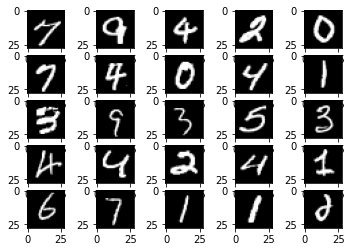

In [2]:
#Save path
path = './data/mnist'
#Transformation to apply to the data
transform = Compose([ToTensor()])
#Download Datasets
train = MNIST(path, train=True, download=True, transform=transform)
test = MNIST(path, train=False, download=True, transform=transform)
#Define dataloaders
train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=1, shuffle=False)
#Visualize one batch
i, (inputs, labels) = next(enumerate(train_dl))
#plot
print(inputs[0].size())
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(inputs[i][0], cmap='gray')
plt.show()

# Model

In [8]:
class Print(Module):
    def forward(self, X):
        print(X.size())
        return X

class Flatten(Module):
    def forward(self, X):
        return X.view(X.size()[0], -1)

class CNN_Cell(Module):
    def __init__(self, n_kernels, conv_size, in_size, stride=(1,1), padding=0):
        super(CNN_Cell, self).__init__()
        #Build model
        n_channels, in_h, in_w = in_size
        self.conv = Conv2d(n_channels, n_kernels, (conv_size, conv_size), stride=stride, padding=padding)
        kaiming_uniform_(self.conv.weight, nonlinearity='relu')
        bn = BatchNorm2d(num_features=n_channels)
        self.act = ReLU()
        self.pool = MaxPool2d((2,2), stride=(2,2))

    def forward(self, X):
        X = self.conv(X)
        X = self.act(X)
        X = self.pool(X)
        return X

class Fully_Connected(Module):
    def __init__(self, n_inputs, layer_sizes, n_outputs):
        super(Fully_Connected, self).__init__()
        #Build model
        self.layers = []
        layer = Linear(n_inputs, layer_sizes[0])
        xavier_uniform_(layer.weight)
        bn = BatchNorm1d(num_features=layer_sizes[0])
        self.layers.extend([layer, bn, ReLU()])
        for i in range(len(layer_sizes) - 1):
            layer = Linear(layer_sizes[i], layer_sizes[i+1])
            xavier_uniform_(layer.weight)
            bn = BatchNorm1d(num_features=layer_sizes[i+1])
            self.layers.extend([layer, bn, ReLU()])
        layer = Linear(layer_sizes[-1], n_outputs)
        xavier_uniform_(layer.weight)
        self.layers.extend([layer, Softmax(dim=1)])
        self.layers = Sequential(*self.layers)

    def forward(self, X):
        return self.layers(X)

class CNN(Module):
    def __init__(self, n_kernels=32, conv_size=3, im_size=(1,28,28)):
        super(CNN, self).__init__()
        #Build model
        padding = 0
        stride = 1
        self.layers = []
        in_size = im_size
        self.layers.append(CNN_Cell(n_kernels, conv_size, in_size, stride=(stride, stride), padding=padding))
        #Conv: Out = (In - kernel_size + 2 * padding)/stride + 1
        #Maxpool (kernel = 2, padding = 0, stride = 2): Out = (In - 2 / 2 + 1)
        in_size = (n_kernels, 
            int((((in_size[1] - conv_size + 2 * padding) / stride + 1) - 2) / 2) + 1, 
            int((((in_size[2] - conv_size + 2 * padding) / stride + 1) - 2) / 2) + 1)
        self.layers.append(CNN_Cell(n_kernels, conv_size, in_size, stride=(stride, stride), padding=padding))
        #Conv: Out = (In - kernel_size + 2 * padding)/stride + 1
        #Maxpool (kernel = 2, padding = 0, stride = 2): Out = (In - 2 / 2 + 1)
        in_size = (n_kernels, 
            int((((in_size[1] - conv_size + 2 * padding) / stride + 1) - 2) / 2) + 1, 
            int((((in_size[2] - conv_size + 2 * padding) / stride + 1) - 2) / 2) + 1)
        #self.layers.append(Print()) #Debugging
        self.layers.append(Flatten())
        self.layers.append(Fully_Connected(n_inputs=in_size[0]*in_size[1]*in_size[2], layer_sizes=[100, 100], n_outputs=10))
        self.layers = Sequential(*self.layers)

    def forward(self, X):
        return self.layers(X)
        

In [10]:
test_model = CNN()
_, (test_data, test_label) = next(enumerate(test_dl))
test_model.eval()
test_model.forward(test_data)

tensor([[0.1543, 0.0953, 0.0874, 0.0438, 0.0990, 0.1114, 0.0829, 0.1304, 0.1258,
         0.0697]], grad_fn=<SoftmaxBackward>)

# Trainer

In [14]:
class Trainer(object):
    def __init__(self, path, model, batch_train=64, batch_test=1024):
        transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
        #load
        train = MNIST(path, train=True, download=True, transform=transform)
        test = MNIST(path, train=False, download=True, transform=transform)
        #dataloaders
        self.train_dl = DataLoader(train, batch_size=batch_train, shuffle=True)
        self.test_dl = DataLoader(test, batch_size=batch_test, shuffle=False)
        self.model = model
        if cuda.is_available():
            self.model.cuda()
        self.batch_train = batch_train

    def train(self, epochs):
        self.model.train()
        if cuda.is_available():
            self.model.cuda()
        #optimization
        criterion = CrossEntropyLoss()
        optimizer = Adam(self.model.parameters(), lr=0.01)
        #train
        losses = []
        for epoch in tqdm(range(epochs), desc='Epochs'):
            running_loss = 0.0
            for i, data in enumerate(self.train_dl):
                inputs, labels = data
                if cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()
                #initialize gradients
                optimizer.zero_grad()
                #predict output
                y = self.model(inputs)
                #calculate loss
                loss = criterion(y, labels)
                #gradient descent
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            
            #print current loss
            avg_loss = running_loss / len(self.train_dl)
            tqdm.write("[%d] loss: %.4f" % (epoch + 1, avg_loss))
            losses.append(avg_loss)
        
        return losses

    def evaluate(self):
        predictions, true_labels = list(), list()
        self.model.cpu()
        for i, (inputs, labels) in enumerate(self.test_dl):
            #outputs
            y = self.model(inputs).detach().numpy()
            y = np.argmax(y, axis=1)
            y = y.reshape((len(y), 1))
            #labels
            true_label = labels.numpy()
            true_label = true_label.reshape((len(true_label), 1))
            #store values
            predictions.append(y)
            true_labels.append(true_label)
        
        predictions, true_labels = np.vstack(predictions), np.vstack(true_labels)
        #accuracy
        acc = accuracy_score(true_labels, predictions)
        return acc

    def predict(self, x):
        x = Tensor([x])
        self.model.eval()
        return self.model(x).detach().numpy()

In [15]:
path = './data/mnist'
model = CNN()
trainer= Trainer(path, model)

[1] loss: 22.0887
[2] loss: 21.7984
[3] loss: 21.7175
[4] loss: 21.7122
[5] loss: 21.7053
[6] loss: 21.6842
[7] loss: 21.6749
[8] loss: 21.6550
[9] loss: 21.6715
[10] loss: 21.6595
[11] loss: 21.6447
[12] loss: 21.6436
[13] loss: 21.6432
[14] loss: 21.6549
[15] loss: 21.6266
[16] loss: 21.6023
[17] loss: 21.6223
[18] loss: 21.6287
[19] loss: 21.6365
[20] loss: 21.6107
[21] loss: 21.6225
[22] loss: 21.6168
[23] loss: 21.6153
[24] loss: 21.5947
[25] loss: 21.6209
[26] loss: 21.5957
[27] loss: 21.6024
[28] loss: 21.6015
[29] loss: 21.6055
[30] loss: 21.5906
[31] loss: 21.5840
[32] loss: 21.6008
[33] loss: 21.5903
[34] loss: 21.6047
[35] loss: 21.6336
[36] loss: 21.5937
[37] loss: 21.5748
[38] loss: 21.5768
[39] loss: 21.6281
[40] loss: 21.5987
[41] loss: 21.5833
[42] loss: 21.5732
[43] loss: 21.5812
[44] loss: 21.5817
[45] loss: 21.5791
[46] loss: 21.5784
[47] loss: 21.5685
[48] loss: 21.5849
[49] loss: 21.5799
[50] loss: 21.5670



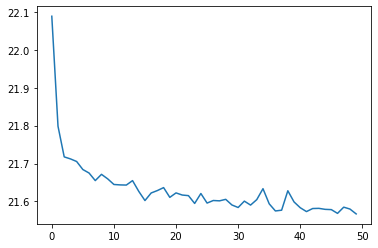

In [16]:
losses = trainer.train(50)
plt.plot(losses)
plt.show()

In [17]:
acc = trainer.evaluate()
print("Accuracy: %.4f" % acc)

Accuracy: 0.9894
